# 核心能力提升班商业智能方向 004期 Week 12

### Thinking 1: GCN/Graph Embedding 都有哪些应用场景

GCN/Graph Embedding是图结构的特征提取器，能够将图中节点信息和节点之间关系提取特征，图结构在生活中有很多应用场景，比如位置关系，人们之间的通信网络，知识图谱，NLP文本之间关系，句子间关系乃至词之间关系，在推荐领域可以是用户与商品的交互等等，这些图结构都能够使用GCN/Graph Embedding来提取特征。

### Thinking 2: 在交通流量预测中，如何使用Graph Embedding，请说明简要的思路

各个路口可以作为节点，路口之间的道路作为边，就可以形成图结构。  
可以用DeepWork的随机游走方法来进行Graph Embedding。  
我觉得用在路上行驶的汽车通过各个路口的顺序序列直接来进行Graph Embedding可能效果会更好。

### Thinking 3: 在文本分类中，如何使用Graph Embedding，请说明简要的思路

文本中可以以词为节点，每个词与其前驱、后继相连作为边。针对句子进行Graph Embedding。但这样就与Word2Vec和Glove一样了。可以考虑使用bi-gram，tri-gram方法，也就是相邻两个或三个词作为节点，甚至可以一句话作为节点，然后再进行Graph Embedding。

### Action 1: Dolphin数据集是 D.Lusseau 等人使用长达 7 年的时间观察新西兰 Doubtful Sound海峡 62 只海豚群体的交流情况而得到的海豚社会关系网络。这个网络具有 62 个节点，159 条边。节点表示海豚，边表示海豚间的频繁接触
数据文件：dolphins.gml  
1）对Dolphin 关系进行Graph Embedding，使用GCN  
2）对Embedding进行可视化（使用PCA呈现在二维平面上）  

In [54]:
import networkx as nx
from networkx import to_numpy_matrix
import matplotlib.pyplot as plt
import numpy as np

In [55]:
# 数据加载，构造图
G = nx.read_gml('data/dolphins.gml')

In [56]:
# 对网络G进行可视化
def plot_graph(G):
    plt.figure()
    pos = nx.spring_layout(G)
    edges = G.edges()
    nx.draw_networkx(G, pos);
    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_size=300, node_color='r', alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=edges, alpha =0.4)
    plt.show()

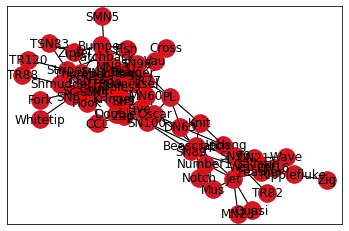

In [57]:
# 可视化
plot_graph(G)

In [58]:
G.nodes()

NodeView(('Beak', 'Beescratch', 'Bumper', 'CCL', 'Cross', 'DN16', 'DN21', 'DN63', 'Double', 'Feather', 'Fish', 'Five', 'Fork', 'Gallatin', 'Grin', 'Haecksel', 'Hook', 'Jet', 'Jonah', 'Knit', 'Kringel', 'MN105', 'MN23', 'MN60', 'MN83', 'Mus', 'Notch', 'Number1', 'Oscar', 'Patchback', 'PL', 'Quasi', 'Ripplefluke', 'Scabs', 'Shmuddel', 'SMN5', 'SN100', 'SN4', 'SN63', 'SN89', 'SN9', 'SN90', 'SN96', 'Stripes', 'Thumper', 'Topless', 'TR120', 'TR77', 'TR82', 'TR88', 'TR99', 'Trigger', 'TSN103', 'TSN83', 'Upbang', 'Vau', 'Wave', 'Web', 'Whitetip', 'Zap', 'Zig', 'Zipfel'))

### 邻接矩阵

In [59]:
# 构建GCN，计算A_hat和D_hat矩阵
order = sorted(list(G.nodes()))
A = to_numpy_matrix(G, nodelist=order)
A

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]])

### 对角阵

In [60]:
I = np.eye(G.number_of_nodes())
A_hat = A + I
A_hat

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 0., 1.]])

### 度矩阵

In [61]:
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))
D_hat

matrix([[7., 0., 0., ..., 0., 0., 0.],
        [0., 9., 0., ..., 0., 0., 0.],
        [0., 0., 5., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 6., 0., 0.],
        [0., 0., 0., ..., 0., 2., 0.],
        [0., 0., 0., ..., 0., 0., 4.]])

In [62]:
# 初始化权重, normal 正态分布 loc均值 scale标准差
W_1 = np.random.normal(loc=0, scale=1, size=(G.number_of_nodes(), 4))
W_2 = np.random.normal(loc=0, size=(W_1.shape[1], 2))

### 激活函数ReLU

In [63]:
# x<0时 结果=0; x>=0时，结果=x
def relu(x):
    return(abs(x)+x)/2

In [64]:
def gcn_layer(A_hat, D_hat, X, W):
    return relu(D_hat**-1 * A_hat * X * W)

In [65]:
# 叠加GCN层，这里只使用单位矩阵作为特征表征，即每个节点被表示为一个 one-hot 编码的类别变量
H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
output = H_2
output

matrix([[2.22880869e-02, 0.00000000e+00],
        [0.00000000e+00, 4.38660632e-01],
        [0.00000000e+00, 1.27573516e-01],
        [3.54513332e-02, 0.00000000e+00],
        [5.14433728e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.17517654e-02],
        [0.00000000e+00, 7.59546546e-02],
        [0.00000000e+00, 4.61057492e-02],
        [5.40038114e-04, 0.00000000e+00],
        [5.67224903e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.30859331e-02],
        [0.00000000e+00, 1.83374743e-01],
        [9.20766634e-02, 0.00000000e+00],
        [0.00000000e+00, 2.08660134e-01],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.49169357e-03],
        [0.00000000e+00, 1.08096220e-01],
        [0.00000000e+00, 3.14926975e-01],
        [0.00000000e+00, 3.55339345e-02],
        [0.00000000e+00, 0.00000000e+00],
        [2.52067517e-02, 1.4918490

In [66]:
# 提取特征表征
feature_representations = {}
nodes = list(G.nodes())
for i in range(len(nodes)):
    feature_representations[nodes[i]] = np.array(output)[i]
feature_representations

{'Beak': array([0.02228809, 0.        ]),
 'Beescratch': array([0.        , 0.43866063]),
 'Bumper': array([0.        , 0.12757352]),
 'CCL': array([0.03545133, 0.        ]),
 'Cross': array([0.51443373, 0.        ]),
 'DN16': array([0., 0.]),
 'DN21': array([0., 0.]),
 'DN63': array([0.        , 0.08175177]),
 'Double': array([0.        , 0.07595465]),
 'Feather': array([0.        , 0.04610575]),
 'Fish': array([0.00054004, 0.        ]),
 'Five': array([0.5672249, 0.       ]),
 'Fork': array([0., 0.]),
 'Gallatin': array([0.        , 0.08308593]),
 'Grin': array([0.        , 0.18337474]),
 'Haecksel': array([0.09207666, 0.        ]),
 'Hook': array([0.        , 0.20866013]),
 'Jet': array([0., 0.]),
 'Jonah': array([0.        , 0.00949169]),
 'Knit': array([0.        , 0.10809622]),
 'Kringel': array([0.        , 0.31492697]),
 'MN105': array([0.        , 0.03553393]),
 'MN23': array([0., 0.]),
 'MN60': array([0.02520675, 0.14918491]),
 'MN83': array([0.00983829, 0.        ]),
 'Mus':

In [67]:
# 不同节点value，绘制不同的颜色
def getValue(value):
    colorList = ['blue','green','purple','yellow','red','pink','orange','black','white','gray','brown','wheat']
    return colorList[int(value)]

In [68]:
# 绘制所选节点的向量
def plot_nodes(nodes, output):
    # 绘制节点向量
    plt.figure(figsize=(12,9))
    # 创建一个散点图的投影
    plt.scatter(output[:, 0], output[:, 1])
    for i, node in enumerate(nodes):
        plt.annotate(node, xy=(output[i, 0], output[i, 1]))        
    plt.show()

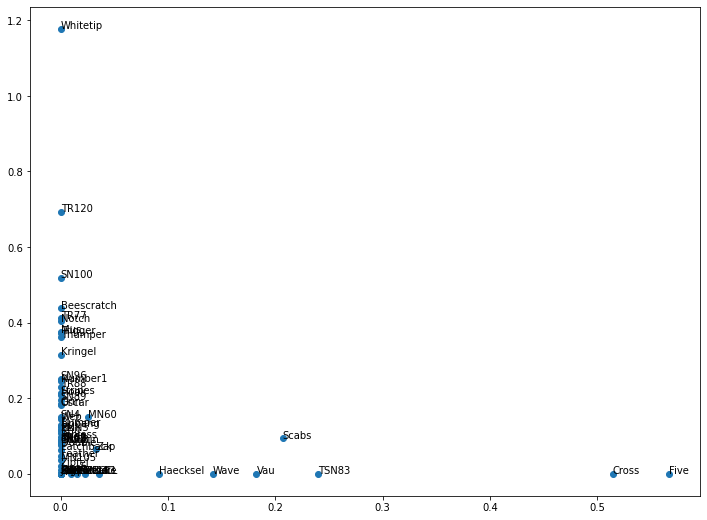

In [69]:
plot_nodes(nodes, np.array(output))

### 去除激活函数ReLU

In [70]:
# 尝试去掉激活函数relu，重新运行一遍，发现效果反而更好
def gcn_layer(A_hat, D_hat, X, W):
    return D_hat**-1 * A_hat * X * W
H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
output = H_2

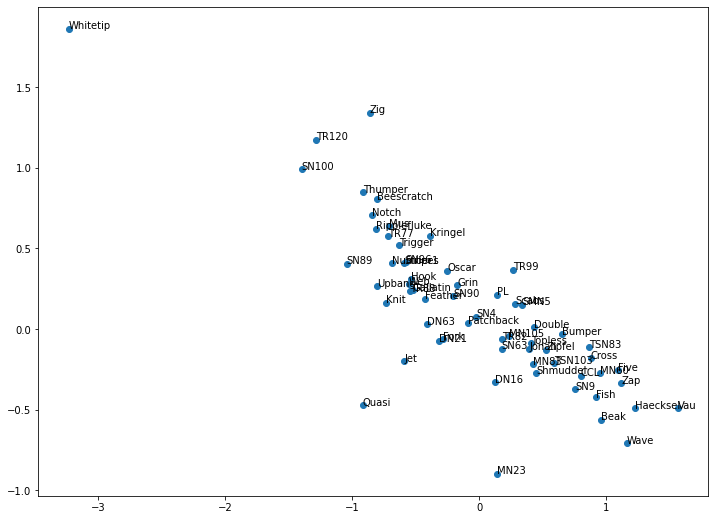

In [71]:
plot_nodes(nodes, np.array(output))

### Action 2: 二手车价格预测
数据集：  
used_car_train_20200313.csv  
used_car_testA_20200313.csv  
数据来自某交易平台的二手车交易记录  
ToDo：给你一辆车的各个属性（除了price字段），预测它的价格  


In [4]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")  # 忽略版本问题

### 数据加载

In [5]:
# 数据加载
train_data = pd.read_csv('data/used_car/used_car_train_20200313.csv', sep=' ')
train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [6]:
test_data = pd.read_csv('data/used_car/used_car_testB_20200421.csv', sep=' ')
test_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,200000,133777,20000501,67.0,0,1.0,0.0,0.0,101,15.0,...,0.236520,0.000241,0.105319,0.046233,0.094522,3.619512,-0.280607,-2.019761,0.978828,0.803322
1,200001,61206,19950211,19.0,6,2.0,0.0,0.0,73,6.0,...,0.261518,0.000000,0.120323,0.046784,0.035385,2.997376,-1.406705,-1.020884,-1.349990,-0.200542
2,200002,67829,20090606,5.0,5,4.0,0.0,0.0,120,5.0,...,0.261691,0.090836,0.000000,0.079655,0.073586,-3.951084,-0.433467,0.918964,1.634604,1.027173
3,200003,8892,20020601,22.0,9,1.0,0.0,0.0,58,15.0,...,0.236050,0.101777,0.098950,0.026830,0.096614,-2.846788,2.800267,-2.524610,1.076819,0.461610
4,200004,76998,20030301,46.0,6,0.0,NaN,0.0,116,15.0,...,0.257000,0.000000,0.066732,0.057771,0.068852,2.839010,-1.659801,-0.924142,0.199423,0.451014


### 缺失值可视化

In [7]:
import matplotlib.pyplot as plt
missing = train_data.isnull().sum()
missing = missing[missing > 0]

<AxesSubplot:>

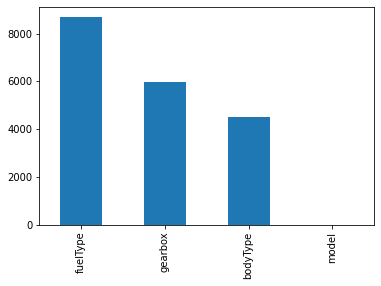

In [8]:
missing.sort_values(ascending=False, inplace=True)
missing.plot.bar()

In [10]:
# sample随机抽取
import missingno as msno
sample = train_data.sample(1000)
sample

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
34814,34814,184088,20040609,13.0,4,2.0,1.0,1.0,218,15.0,...,0.264459,0.000442,0.136930,0.081475,0.017568,2.136333,-2.337916,1.933077,-1.249649,0.416414
57313,57313,911,20090304,29.0,0,1.0,0.0,0.0,60,7.0,...,0.236056,0.109600,0.135640,0.046375,0.090780,-3.905510,2.398410,-0.435854,1.044438,1.069787
91662,91662,8519,20040105,63.0,0,3.0,1.0,0.0,136,15.0,...,0.260129,0.095736,0.081084,0.054971,0.070134,-3.860271,0.424239,0.299589,0.017552,-0.697858
116601,116601,98256,20031008,5.0,5,1.0,0.0,0.0,75,15.0,...,0.236639,0.000294,0.122737,0.065600,0.091268,3.132806,-0.857717,-0.251413,0.997729,0.577695
116185,116185,35961,20050601,107.0,25,1.0,0.0,0.0,73,12.5,...,0.222949,0.092438,0.102767,0.054090,0.150354,-2.773462,1.877831,-0.573391,2.478345,-2.212607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122261,122261,43360,20031109,4.0,4,2.0,0.0,1.0,116,15.0,...,0.262480,0.000083,0.134354,0.065710,0.027592,2.516146,-1.917947,0.643969,-1.300081,0.018701
82081,82081,713,19960707,4.0,4,0.0,0.0,0.0,150,15.0,...,0.265498,0.118758,0.157218,0.021626,0.040201,-4.949267,1.673072,-0.939842,-1.927851,-0.252884
51712,51712,157317,20010909,137.0,30,1.0,0.0,0.0,53,8.0,...,0.228459,0.000000,0.131249,0.036416,0.129069,3.790299,-0.130718,-2.471221,1.075655,-1.501522
149239,149239,853,20020406,52.0,10,4.0,0.0,0.0,163,15.0,...,0.274202,0.123265,0.055430,0.055779,0.046197,-6.079772,0.451285,0.791266,-0.796143,-2.260585


### 图中横白线是缺失值

<AxesSubplot:>

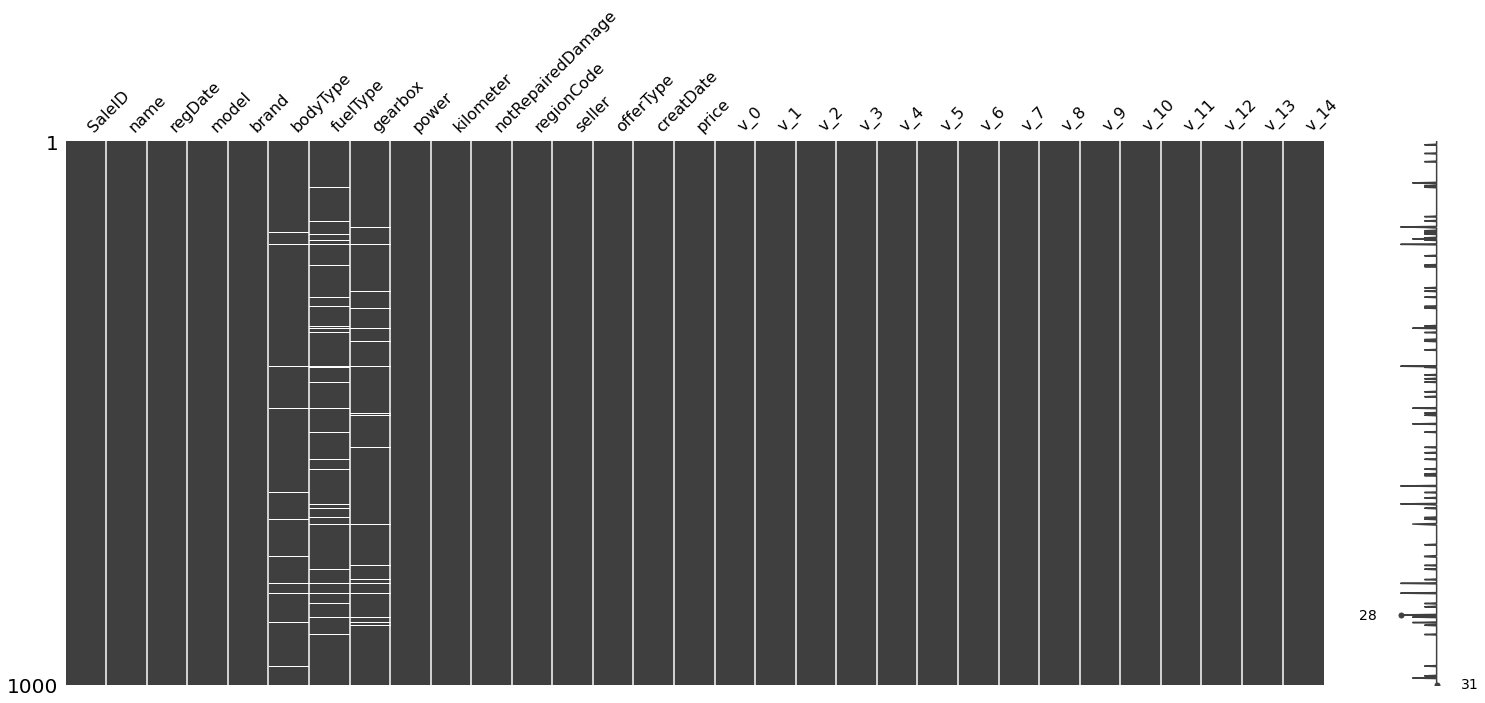

In [11]:
msno.matrix(sample)

### 图中缺口是缺失值

<AxesSubplot:>

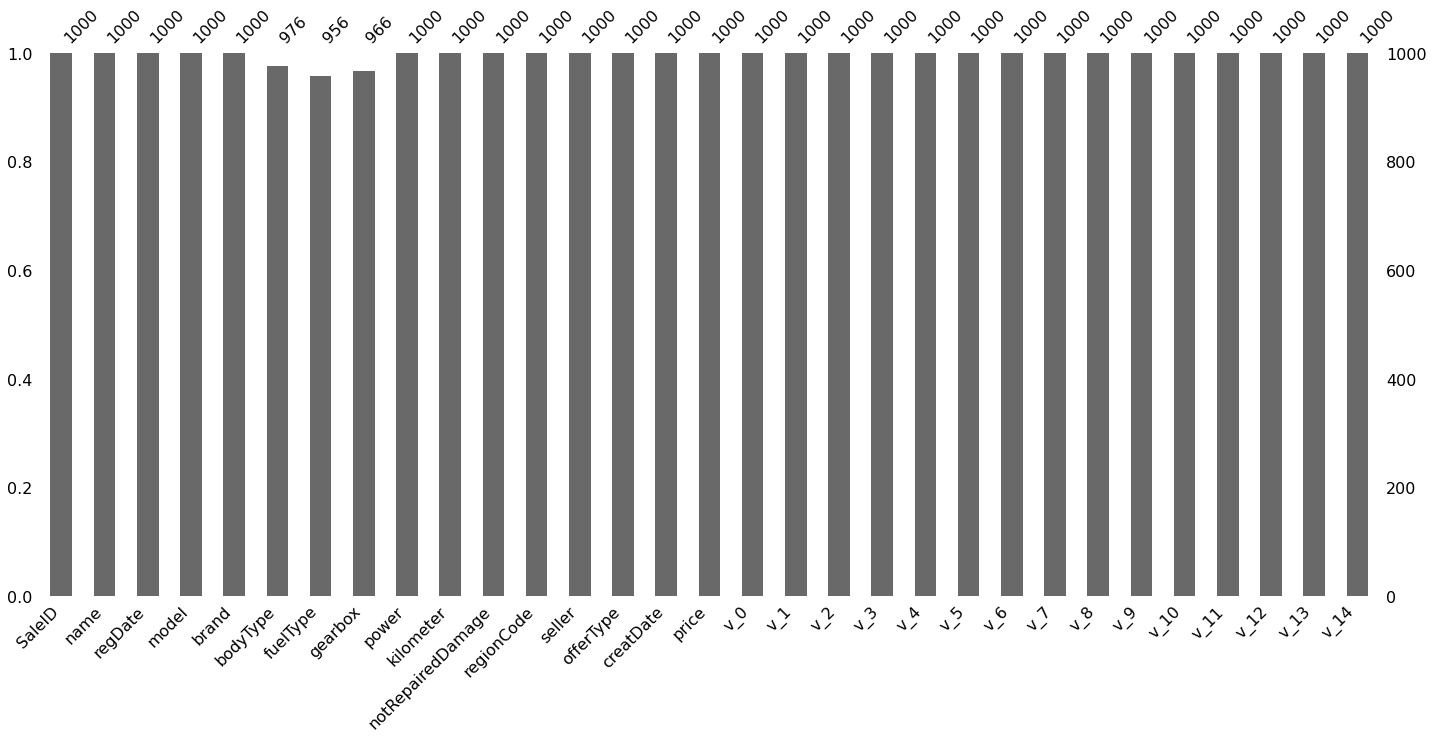

In [12]:
msno.bar(sample)

### 热力图缺失值展示 缺失值字段对其他字段影响

<AxesSubplot:>

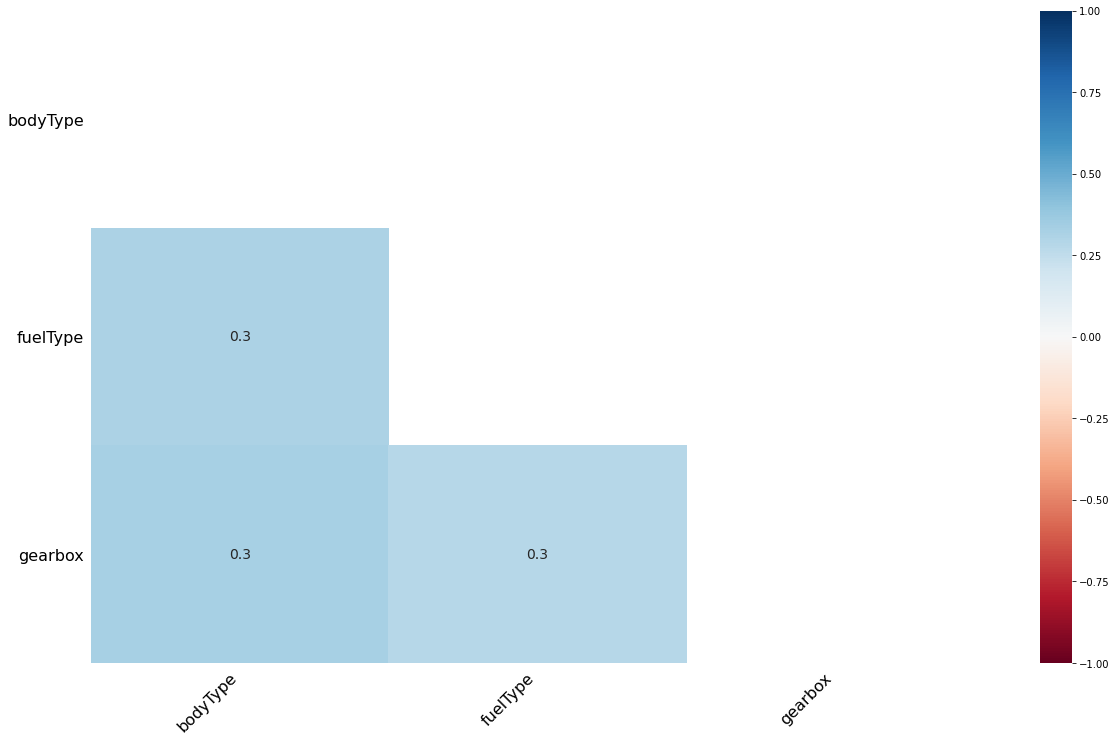

In [13]:
msno.heatmap(sample)

### price 分布

<AxesSubplot:title={'center':'Johnson SU'}, xlabel='price'>

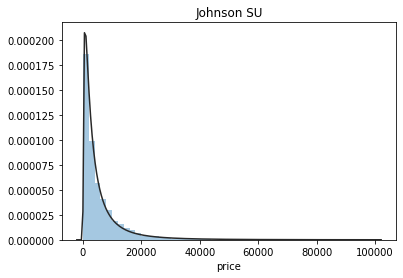

In [15]:
import seaborn as sns
import scipy.stats as st
# 查看price的分布
y = train_data['price']
plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)

<AxesSubplot:title={'center':'Normal'}, xlabel='price'>

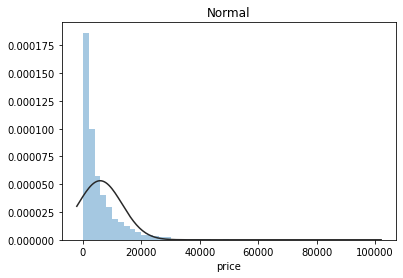

In [16]:
plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)

<AxesSubplot:title={'center':'log Normal'}, xlabel='price'>

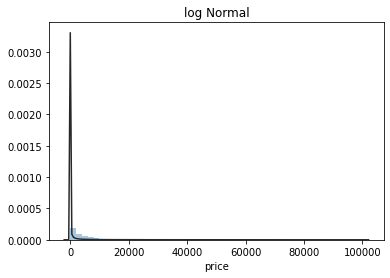

In [17]:
plt.title('log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

Skewness: 3.3464867626369608
Skewness: 18.995183355632562


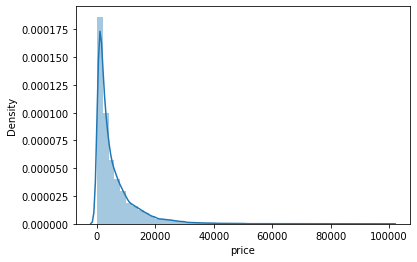

In [18]:
sns.distplot(y)
print('Skewness:', y.skew())# 峰度
print('Skewness:', y.kurt())# 偏度

(array([1.23906e+05, 1.89270e+04, 4.91800e+03, 1.34000e+03, 4.71000e+02,
        1.88000e+02, 1.24000e+02, 6.00000e+01, 4.80000e+01, 1.80000e+01]),
 array([1.10000e+01, 1.00098e+04, 2.00086e+04, 3.00074e+04, 4.00062e+04,
        5.00050e+04, 6.00038e+04, 7.00026e+04, 8.00014e+04, 9.00002e+04,
        9.99990e+04]),
 <BarContainer object of 10 artists>)

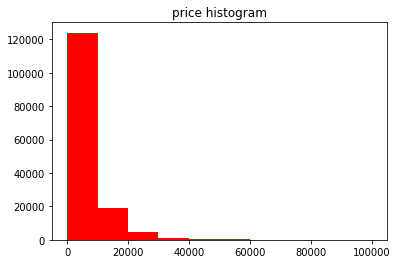

In [19]:
# price 直方图
plt.title('price histogram')
plt.hist(y, color='r')

(array([   56.,   223.,  1508.,  6232., 22319., 35387., 39059., 33184.,
        11123.,   909.]),
 array([ 2.39789527,  3.30939729,  4.22089931,  5.13240133,  6.04390335,
         6.95540537,  7.86690739,  8.77840941,  9.68991143, 10.60141345,
        11.51291546]),
 <BarContainer object of 10 artists>)

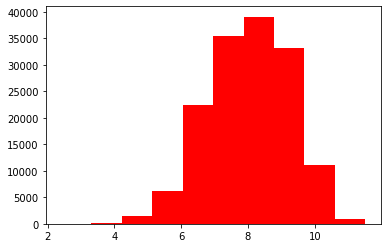

In [20]:
import numpy as np
plt.hist(np.log(y), color='r')

In [22]:
%%time
# 一行代码生成报告
# import pandas_profiling as pp
# report = pp.ProfileReport(train_data)
# # 导出为html
# report.to_file('report.html')

In [23]:
# 将regDate 转换为汽车注册时间（即时间diff）
dates = pd.to_datetime(train_data['regDate'], format='%Y%m%d', errors='coerce')
min_date = pd.to_datetime('19910101', format='%Y%m%d')

train_data['regTime'] = (dates - min_date).dt.days
test_data['regTime'] = (pd.to_datetime(train_data['regDate'], format='%Y%m%d', errors='coerce') - min_date).dt.days

In [24]:
# 将createDate转换为汽车售卖时间（即时间diff）
train_data['creatTime'] = (pd.to_datetime(train_data['creatDate'], format='%Y%m%d', errors='coerce') - min_date).dt.days
test_data['creatTime'] = (pd.to_datetime(test_data['creatDate'], format='%Y%m%d', errors='coerce') - min_date).dt.days

In [25]:
# 汽车使用时间 
train_data['usedTime'] = train_data['creatTime'] - train_data['regTime']
test_data['usedTime'] = test_data['creatTime'] - test_data['regTime']

In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            150000 non-null  int64  
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

In [27]:
#修改异常数据
train_data['power'][train_data['power']>600]=600
test_data['power'][test_data['power']>600]=600

In [28]:
# 众数补全
train_data['notRepairedDamage'].replace('-', '0.0', inplace=True)
train_data['notRepairedDamage'] = train_data['notRepairedDamage'].astype('float64')
test_data['notRepairedDamage'].replace('-', '0.0', inplace=True)
test_data['notRepairedDamage'] = test_data['notRepairedDamage'].astype('float64')

In [29]:
# 找到数值类型的特征
numerical_cols = train_data.select_dtypes(exclude='object').columns

In [30]:
feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','price', 'seller']]

In [31]:
# 提取特征列
X_data = train_data[feature_cols]
Y_data = train_data['price']
X_test = test_data[feature_cols]

In [32]:
# 定义统计函数，方便了解数据分布
def show_stats(data):
    print('min :', np.min(data))
    print('max :', np.max(data))
    print('ptp :', np.ptp(data))
    print('mean:', np.mean(data))
    print('std :', np.std(data))
    print('var :', np.var(data))

In [33]:
print('训练集 Price的统计情况')
show_stats(Y_data)

训练集 Price的统计情况
min : 11
max : 99999
ptp : 99988
mean: 5923.327333333334
std : 7501.973469876635
var : 56279605.942732885


In [34]:
# 缺失值补全
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

### 神经网络实现预测

In [35]:
import tensorflow

In [36]:
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [37]:
X = np.array(X_data)
y = np.array(Y_data).reshape(-1,1)
X_ = np.array(X_test)
X.shape, y.shape, X_.shape

((150000, 30), (150000, 1), (50000, 30))

In [38]:
# 数据规范化
ss = MinMaxScaler()
X = ss.fit_transform(X)
X_ = ss.transform(X_)

In [39]:
#切分数据集
x_train,x_test,y_train,y_test = train_test_split(X, y,test_size = 0.2)

In [40]:
model = keras.Sequential([
        keras.layers.Dense(200,activation='relu',input_shape=[X.shape[1]]), 
        keras.layers.Dense(300,activation='relu'), 
        keras.layers.Dense(200,activation='relu'), 
        keras.layers.Dense(1)])
model.compile(loss='mean_absolute_error', optimizer='Adam')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [41]:
%%time
model.fit(x_train,y_train,batch_size = 2048,epochs=270)

Epoch 1/270
120000/120000 [==============================] - 2s 13us/sample - loss: 5604.5568
Epoch 2/270
120000/120000 [==============================] - 0s 2us/sample - loss: 4281.7382
Epoch 3/270
120000/120000 [==============================] - 0s 2us/sample - loss: 3656.2400
Epoch 4/270
120000/120000 [==============================] - 0s 2us/sample - loss: 2036.2595
Epoch 5/270
120000/120000 [==============================] - 0s 2us/sample - loss: 1429.7002
Epoch 6/270
120000/120000 [==============================] - 0s 2us/sample - loss: 1246.1755
Epoch 7/270
120000/120000 [==============================] - 0s 2us/sample - loss: 1139.5526
Epoch 8/270
120000/120000 [==============================] - 0s 2us/sample - loss: 1063.8206
Epoch 9/270
120000/120000 [==============================] - 0s 2us/sample - loss: 1006.9012
Epoch 10/270
120000/120000 [==============================] - 0s 2us/sample - loss: 963.6855
Epoch 11/270
120000/120000 [==============================] - 0s 3us/

In [43]:
from sklearn.metrics import mean_absolute_error
#比较训练集和测试集效果
mean_absolute_error(y_train,model.predict(x_train))

482.97061344326335

In [44]:
mean_absolute_error(y_test,model.predict(x_test))

492.63905728441875

In [45]:
y_=model.predict(X_)
show_stats(y_)

min : 14.563715
max : 104592.836
ptp : 104578.27
mean: 5897.214
std : 7305.0825
var : 53364228.0


In [46]:
#输出结果预测
data_test_price = pd.DataFrame(y_,columns = ['price'])
results = pd.concat([test_data['SaleID'],data_test_price],axis = 1)
results.to_csv('results_MLP.csv',sep = ',',index = None)